## Telecom User Data Analysis

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from statistics import mean
from pandas_profiling import ProfileReport
import numpy as np
import json
import datetime
import math
import statsmodels.api as sm

from datetime import timedelta, datetime

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import seaborn as sns


### Data Preprocessing

In [2]:
df = pd.read_csv("../data/telcom.csv")

In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,4/4/19 12:01,770.0,4/25/19 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16457E+15,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311450e+19,4/9/19 13:04,235.0,4/25/19 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311450e+19,4/9/19 17:42,1.0,4/25/19 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311450e+19,4/10/19 0:31,486.0,4/25/19 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311450e+19,4/12/19 20:10,565.0,4/25/19 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [4]:
### Check for sufficiency of data to answer objectives by reviewing the objective and 
### available data. And check the number of observations and required sample size.

In [5]:
# generate pipelines
def generate_pipeline(type_="numeric",x=1):
    pipeline = None
    if type_ == "numeric":
        pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', MinMaxScaler())
        ])
    elif type_ == "categorical":
        pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    else:
        pipeline = np.zeros(x)
    return pipeline



In [6]:
# test pipeline
numeric_pipeline = generate_pipeline("numeric")
assert isinstance(numeric_pipeline,Pipeline)

In [7]:
categorical_pipeline = generate_pipeline("categorical")
assert isinstance(numeric_pipeline,Pipeline)

In [8]:
def store_features(df,type_,value):
    features = [None]
    if type_ == "numeric":
        features = df.select_dtypes(include=value).columns.tolist()
    elif type_ == "categorical":
        features = df.select_dtypes(exclude=value).columns.tolist()
    return features


In [9]:
categorical_features = store_features(df,"categorical","number")

In [10]:
# testing function
numerical_features = store_features(df,"numeric","number")

In [11]:
len(numerical_features)

50

In [12]:
assert len(numerical_features)>0

In [13]:
### checking for duplicates

In [14]:
def generate_transformation(pipeline,df,type_,value):
    transformation = None
    if type_=="numeric":
        transformation=pipeline.fit_transform(df.select_dtypes(include=value))
    elif type_ == "categorical":
        transformation=pipeline.fit_transform(df.select_dtypes(exclude=value))
    return transformation

In [15]:
def frame_transforms(transform,features):
    return pd.DataFrame(transform,columns=features)

In [16]:
def handle_missing_values_numeric(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mean
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df.fillna(df[key].mean().round(1), inplace=True)
    return missing_percentage, df

In [17]:
handle_missing_values_numeric(df,numerical_features)

(12.5,
            Bearer Id                   Start      Start ms  \
 0       1.311450e+19            4/4/19 12:01  7.700000e+02   
 1       1.311450e+19            4/9/19 13:04  2.350000e+02   
 2       1.311450e+19            4/9/19 17:42  1.000000e+00   
 3       1.311450e+19            4/10/19 0:31  4.860000e+02   
 4       1.311450e+19           4/12/19 20:10  5.650000e+02   
 ...              ...                     ...           ...   
 149996  7.277830e+18            4/29/19 7:28  4.510000e+02   
 149997  7.349880e+18            4/29/19 7:28  4.830000e+02   
 149998  1.311450e+19            4/29/19 7:28  2.830000e+02   
 149999  1.311450e+19            4/29/19 7:28  6.960000e+02   
 150000  1.013887e+19  10138871842091134976.0  1.013887e+19   
 
                            End        End ms     Dur. (ms)          IMSI  \
 0                4/25/19 14:35  6.620000e+02  1.823652e+06  2.082014e+14   
 1                 4/25/19 8:15  6.060000e+02  1.365104e+06  2.082019e+14   
 2  

In [18]:
def handle_missing_values_categorical(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mode
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df[key] = df[key].fillna(df[key].mode()[0])
    return missing_percentage, df

In [19]:
handle_missing_values_categorical(df,categorical_features)

(0.0,
            Bearer Id                   Start      Start ms  \
 0       1.311450e+19            4/4/19 12:01  7.700000e+02   
 1       1.311450e+19            4/9/19 13:04  2.350000e+02   
 2       1.311450e+19            4/9/19 17:42  1.000000e+00   
 3       1.311450e+19            4/10/19 0:31  4.860000e+02   
 4       1.311450e+19           4/12/19 20:10  5.650000e+02   
 ...              ...                     ...           ...   
 149996  7.277830e+18            4/29/19 7:28  4.510000e+02   
 149997  7.349880e+18            4/29/19 7:28  4.830000e+02   
 149998  1.311450e+19            4/29/19 7:28  2.830000e+02   
 149999  1.311450e+19            4/29/19 7:28  6.960000e+02   
 150000  1.013887e+19  10138871842091134976.0  1.013887e+19   
 
                            End        End ms     Dur. (ms)          IMSI  \
 0                4/25/19 14:35  6.620000e+02  1.823652e+06  2.082014e+14   
 1                 4/25/19 8:15  6.060000e+02  1.365104e+06  2.082019e+14   
 2   

In [20]:
# test transformations
numeric_transformation = generate_transformation(numeric_pipeline,df,"numeric","number")

In [21]:
numeric_df = frame_transforms(numeric_transformation,numerical_features)

In [22]:
def split_data(df,response_variable,split_ratio,get):
    X = df.drop(response_variable, axis=1)
    y = df[response_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, 
                                                    random_state=1121218)
    if get == "X_train":
        return X_train
    elif get == "X_test":
        return X_test
    elif get == "y_train":
        return y_train
    else:
        return y_test
    
    

In [23]:
numeric_transformation_ = generate_transformation(numeric_pipeline,
                                                 pd.DataFrame(split_data(df,"Total DL (Bytes)",0.3,"X_train")),
                                                 "numeric","number")

In [24]:
### Check for column organization and naming and correct them.

In [25]:
### Check for missing values and either fill them with a value that will, in no way, 
### affect the analysis or remove the record.

In [26]:
def top_x_column(df, x, column,color,online=False):
    handsets_df = pd.DataFrame(columns = [column])
    handsets_df['type'] = df[column].to_list()
    handsets = handsets_df['type'].value_counts()
    fig,ax = plt.subplots()
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.set_title(f"The {x} Most Frequent {column}")
    handsets[:x].plot(ax=ax,kind='bar',color=color)
    handset_counts = handsets.to_dict()
    top_x = list(handset_counts.keys())
    if online:
        return fig,top_x[:x]
    else:
        return top_x[:x]
    

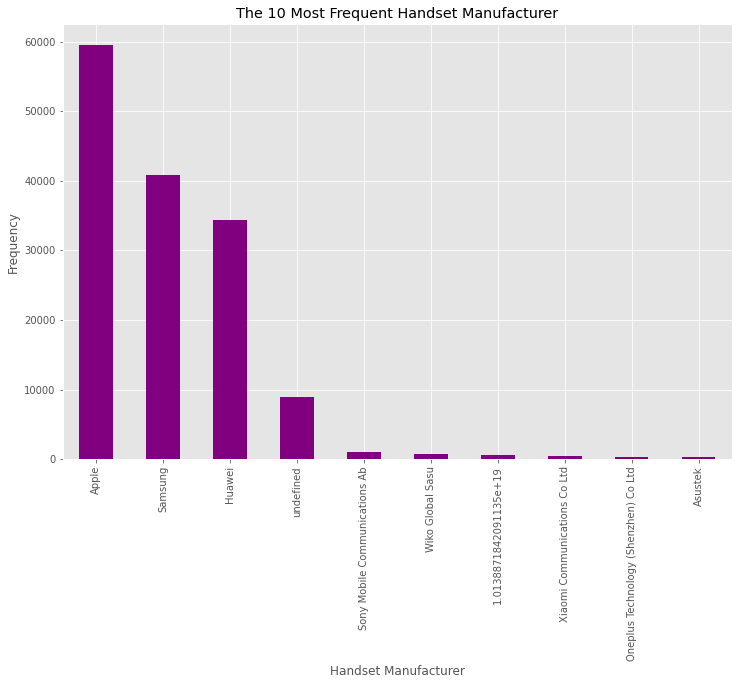

In [27]:
# identifying the top 10 handsets used by the customers.
values = top_x_column(df,10,"Handset Manufacturer","purple")

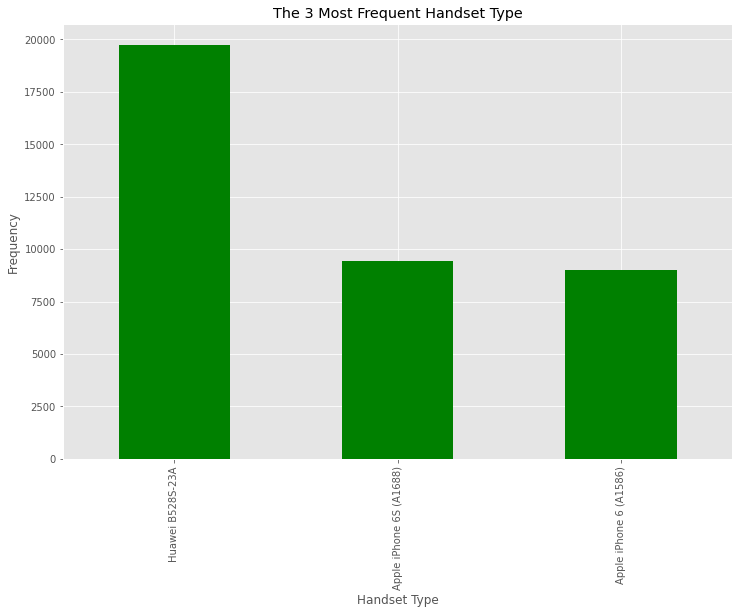

In [28]:
values = top_x_column(df,3,"Handset Type","green")

In [29]:
values

['Huawei B528S-23A', 'Apple iPhone 6S (A1688)', 'Apple iPhone 6 (A1586)']

In [30]:
# Identify the top 5 handsets per top 3 handset manufacturer
def top_x_by_y_cols(df,col_1,col_2,x,y):
    result_df = []
    by_manufacture = df.groupby(col_1,sort=True)
    values = top_x_column(df,x,col_1,"purple")


    for manufacturer, frame in by_manufacture:
        if manufacturer in values:
            result_df.append(frame.sort_values(by=[col_2], ascending=True)[col_2].head(5))
    return result_df
    

[50178     Apple iPad (A1823)
 50098     Apple iPad (A1823)
 40765     Apple iPad (A1823)
 57874     Apple iPad (A1823)
 114763    Apple iPad (A1823)
 Name: Handset Type, dtype: object,
 77840        Huawei Ale-Ul00
 17997        Huawei Ale-Ul00
 99869       Huawei Ascend G6
 99247       Huawei Ascend G6
 5655     Huawei Ascend G620S
 Name: Handset Type, dtype: object,
 10522    Samsung 2018 Galaxy J4
 91735    Samsung 2018 Galaxy J4
 95269    Samsung 2018 Galaxy J4
 80690    Samsung 2018 Galaxy J4
 10574    Samsung 2018 Galaxy J4
 Name: Handset Type, dtype: object]

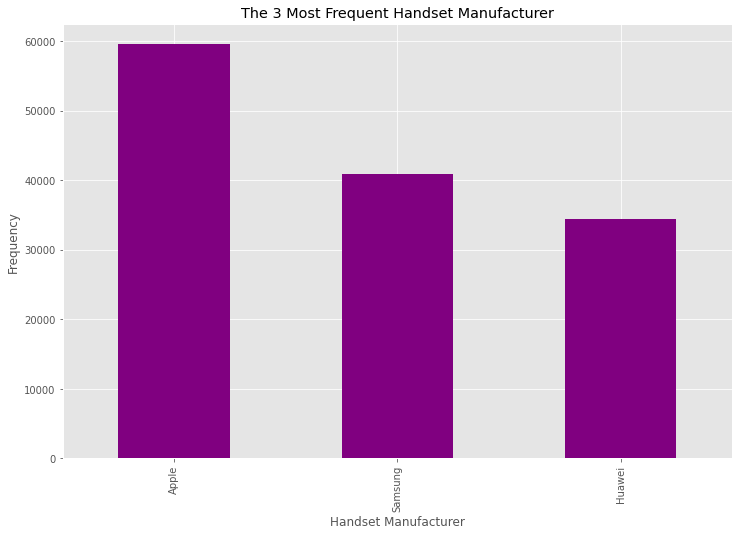

In [31]:
top_x_by_y_cols(df,'Handset Manufacturer','Handset Type',3,5)

In [32]:
# Aggregation per user the following information in the column  
# number of xDR sessions
# Session duration
# the total download (DL) and upload (UL) data
# the total data volume (in Bytes) during this session for each application


def aggregation_cols(df,col_1,col_2,trim=False):
    
    grouped = df.groupby(col_1).agg({col_2: [min, max, mean]}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    if trim:
        return grouped.describe()
    return grouped

In [33]:
aggregation_cols(df,'MSISDN/Number','Bearer Id',True)

,Bearer Id_min,Bearer Id_max,Bearer Id_mean
count,1.068570e+05,1.068570e+05,1.068570e+05
mean,9.861426e+18,9.885904e+18,9.873743e+18
std,2.874549e+18,2.877143e+18,2.872758e+18
min,6.917540e+18,6.917540e+18,6.917540e+18
25%,7.277830e+18,7.349880e+18,7.313855e+18
50%,7.349880e+18,7.349880e+18,7.349880e+18
75%,1.304240e+19,1.311450e+19,1.307845e+19
max,1.318650e+19,1.318650e+19,1.318650e+19


In [34]:
aggregation_cols(df,'MSISDN/Number',"Dur. (ms)",True)

,Dur. (ms)_min,Dur. (ms)_max,Dur. (ms)_mean
count,1.068570e+05,1.068570e+05,1.068570e+05
mean,9.670547e+04,9.488262e+13,8.900819e+10
std,6.860343e+04,3.101617e+16,2.909584e+13
min,7.142000e+03,7.142000e+03,7.142000e+03
25%,5.095100e+04,5.795400e+04,5.641000e+04
50%,8.639900e+04,8.640100e+04,8.640000e+04
75%,1.253680e+05,1.432080e+05,1.339125e+05
max,1.573420e+06,1.013887e+19,9.511137e+15


In [35]:
aggregation_cols(df,'MSISDN/Number','Total UL (Bytes)',True)

,Total UL (Bytes)_min,Total UL (Bytes)_max,Total UL (Bytes)_mean
count,1.068570e+05,1.068570e+05,1.068570e+05
mean,3.906669e+07,9.488266e+13,8.904921e+10
std,1.126762e+07,3.101617e+16,2.909584e+13
min,2.866892e+06,2.866892e+06,2.866892e+06
25%,3.105584e+07,3.544137e+07,3.419707e+07
50%,3.878054e+07,4.351798e+07,4.112708e+07
75%,4.684224e+07,5.122037e+07,4.808044e+07
max,7.833131e+07,1.013887e+19,9.511137e+15


In [36]:
aggregation_cols(df,'MSISDN/Number','Total DL (Bytes)',True)

,Total DL (Bytes)_min,Total DL (Bytes)_max,Total DL (Bytes)_mean
count,1.068570e+05,1.068570e+05,1.068570e+05
mean,4.100965e+08,9.488312e+13,8.946327e+10
std,2.429135e+08,3.101617e+16,2.909584e+13
min,7.114041e+06,8.827082e+06,8.827082e+06
25%,1.956286e+08,2.990565e+08,2.762679e+08
50%,3.891644e+08,5.228791e+08,4.562471e+08
75%,6.119649e+08,7.137620e+08,6.338123e+08
max,9.029696e+08,1.013887e+19,9.511137e+15


## EDA Analysis

In [45]:
#Describe all  relevant variables and associated data types
# Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & 
# their importance for the global objective.
# Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters 
# for each quantitative variable and provide useful interpretation.

def non_graphical_analysis(df,features,type_,opt,x_=1,y_=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x_:
                result = pd.DataFrame(df[key].describe())
    elif type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x_:
                if opt=="regression":
                    y = df[features[y_]]
                    x = df[[key]]
                    x = sm.add_constant(x)
                    model = sm.OLS(y, x).fit()
                    result =  model.summary()
                elif opt=="corr":
                    result = pd.DataFrame(df[[key,features[y_]]].corr())
    elif type_ == "multivariate":
        result = pd.DataFrame(df[features].corr())
    return result
        

In [40]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",1)

,Start ms
count,1.500010e+05
mean,6.666622e-06
std,2.581980e-03
min,0.000000e+00
25%,2.465758e-17
50%,4.921652e-17
75%,7.387410e-17
max,1.000000e+00


In [41]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",2)

,Start ms
count,1.500010e+05
mean,6.666622e-06
std,2.581980e-03
min,0.000000e+00
25%,2.465758e-17
50%,4.921652e-17
75%,7.387410e-17
max,1.000000e+00


In [42]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",3)

,Start ms
count,1.500010e+05
mean,6.666622e-06
std,2.581980e-03
min,0.000000e+00
25%,2.465758e-17
50%,4.921652e-17
75%,7.387410e-17
max,1.000000e+00


In [43]:
non_graphical_analysis(numeric_df,numerical_features,"bivariate","regression",36,49)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total DL (Bytes)   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                -1.665e-11
Date:                Wed, 11 May 2022   Prob (F-statistic):               1.00
Time:                        13:08:01   Log-Likelihood:             6.8104e+05
No. Observations:              150001   AIC:                        -1.362e+06
Df Residuals:                  149999   BIC:                        -1.362e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.667e-06   1.34e-05      0.499      0.618   -1.95e-05    3.29e-05
Google DL (Bytes)  1.015e-12   2.31e-05   4.39e-08      1.000   -4.53e-05    4.53e-05
===============================================================================
Omnibus:                   879335.103   Durbin-Watson:                    1.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   140622187537500.250
Skew:                         387.296   Prob(JB):                          0.00
Kurtosis:                  149999.000   Cond. No.                          4.40
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
non_graphical_analysis(numeric_df,numerical_features,"bivariate","corr",1,4)

,Start ms,IMSI
Start ms,1.000000,0.041806
IMSI,0.041806,1.000000


In [64]:
# Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options 
# for each variable and interpret your findings.

def graphical_analysis(df,features,type_,opt,x=1,y=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x:
                if opt == 'box':
                    return df.boxplot(column=[key], grid=False, color='black')
                elif opt == 'hist':
                    return df.hist(column=[key], grid=False, edgecolor='black')
                elif opt == 'curve':
                    return sns.kdeplot(df[key])
    if type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x:
                if opt == "scatter":
                    plt.scatter(df[features[x]], df[features[y]])
                    plt.title(f'{features[x]} vs {features[y]}')
                    plt.xlabel(f'{features[x]}')
                    plt.ylabel(f'{features[y]}')
                
    

array([[<AxesSubplot:title={'center':'Start ms'}>]], dtype=object)

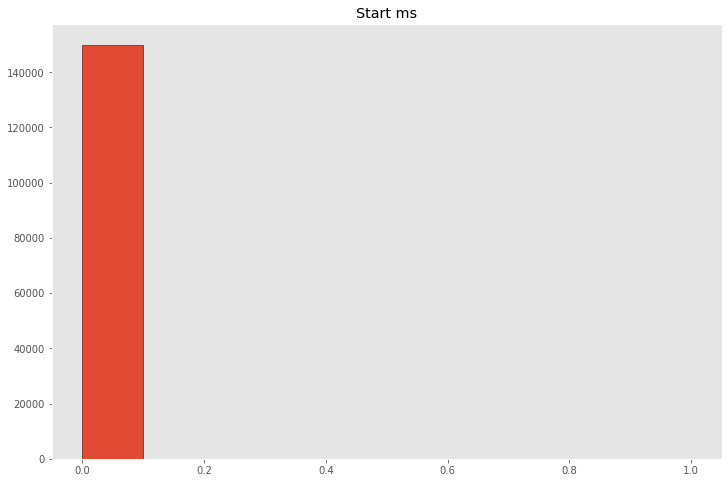

In [65]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=1)

array([[<AxesSubplot:title={'center':'End ms'}>]], dtype=object)

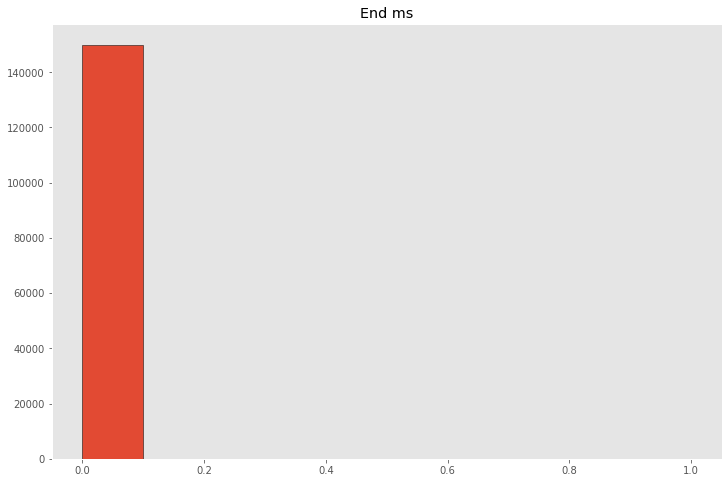

In [66]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=2)

array([[<AxesSubplot:title={'center':'Dur. (ms)'}>]], dtype=object)

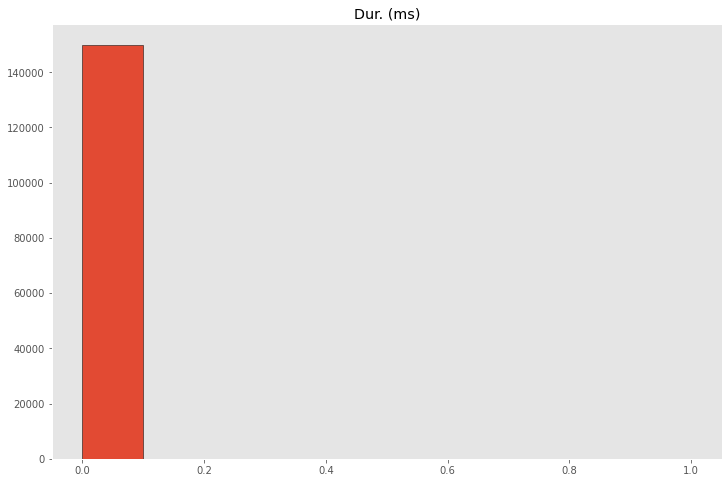

In [67]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=3)

<AxesSubplot:>

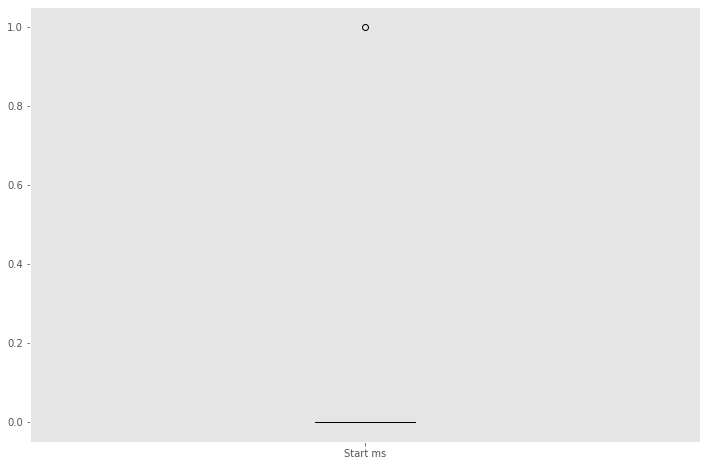

In [68]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",1)

<AxesSubplot:>

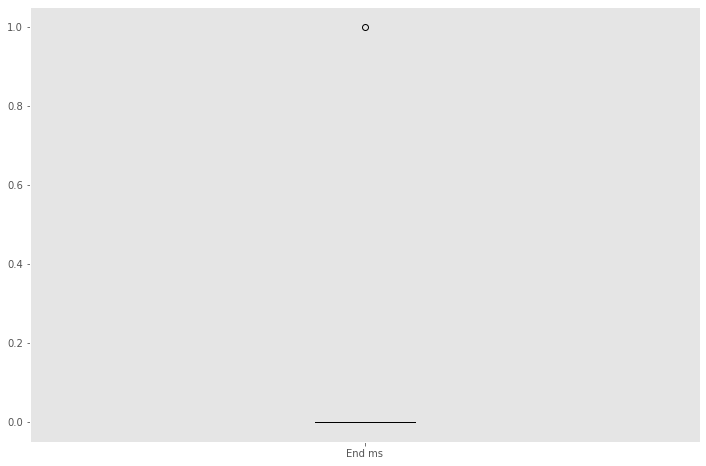

In [69]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=2)

<AxesSubplot:>

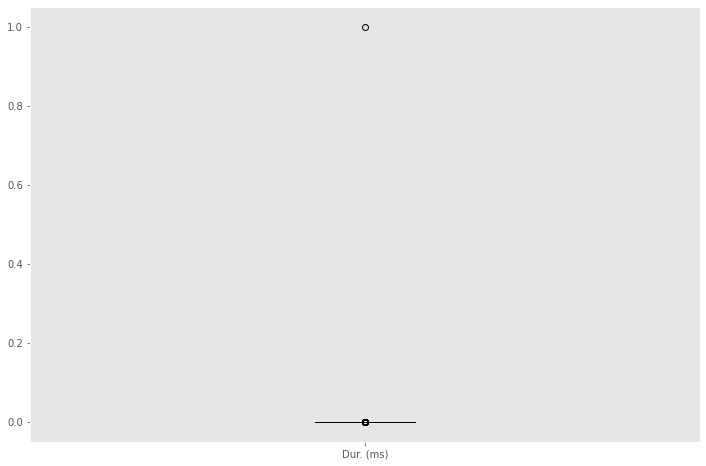

In [70]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=3)

<AxesSubplot:>

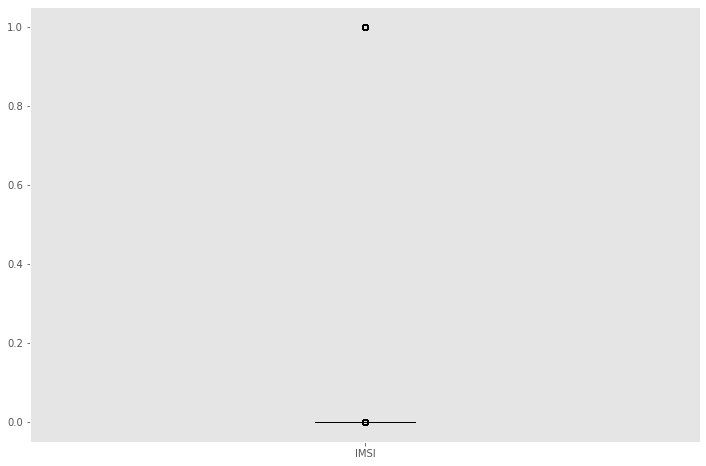

In [71]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=4)

<AxesSubplot:xlabel='Start ms', ylabel='Density'>

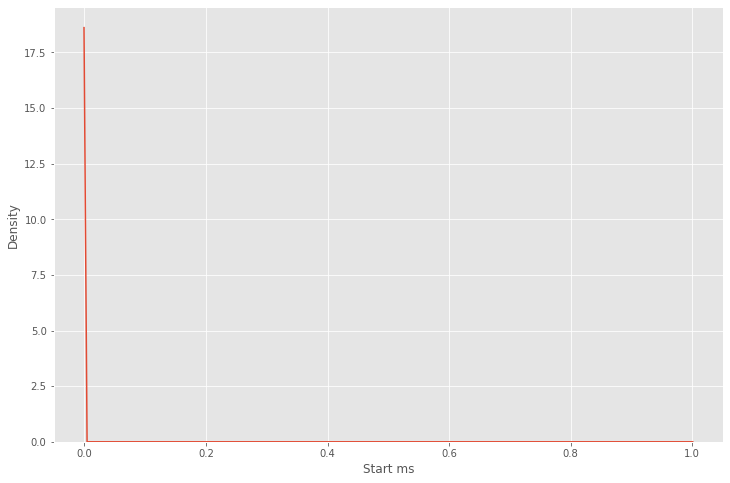

In [72]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=1)

<AxesSubplot:xlabel='End ms', ylabel='Density'>

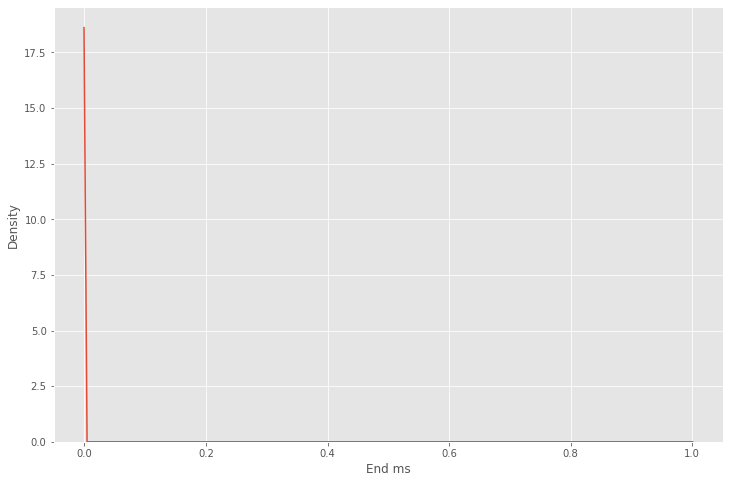

In [73]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=2)

<AxesSubplot:xlabel='Dur. (ms)', ylabel='Density'>

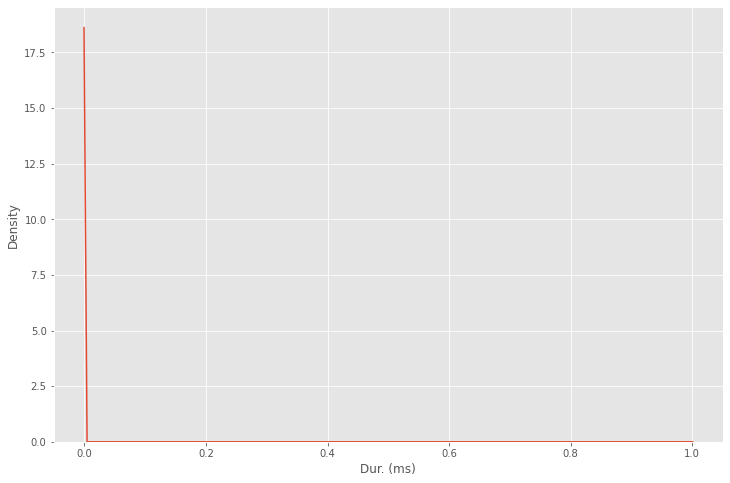

In [74]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=3)

<AxesSubplot:xlabel='IMSI', ylabel='Density'>

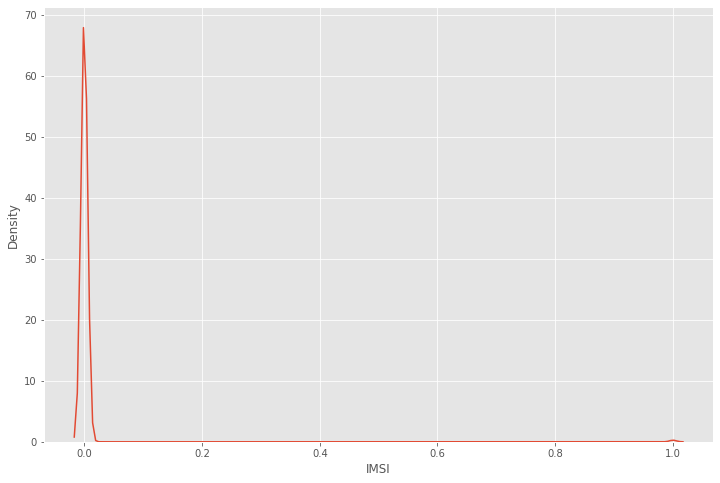

In [75]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=4)

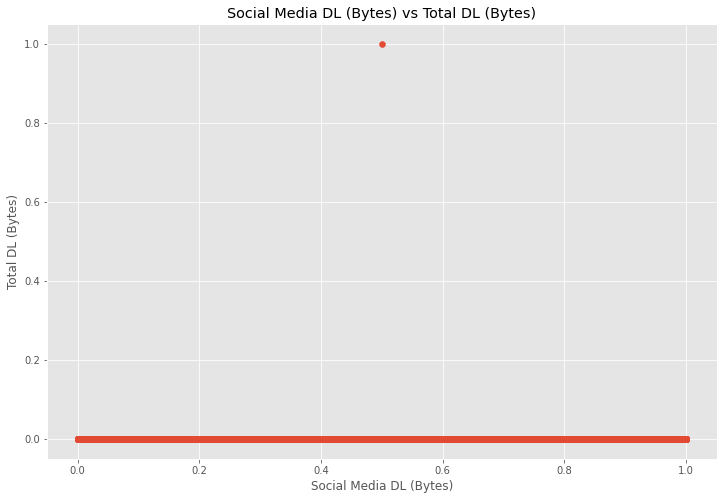

In [76]:
# Bivariate Analysis – explore the relationship between each application & 
# the total DL+UL data using appropriate methods and interpret your findings. 
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=34,y=49)

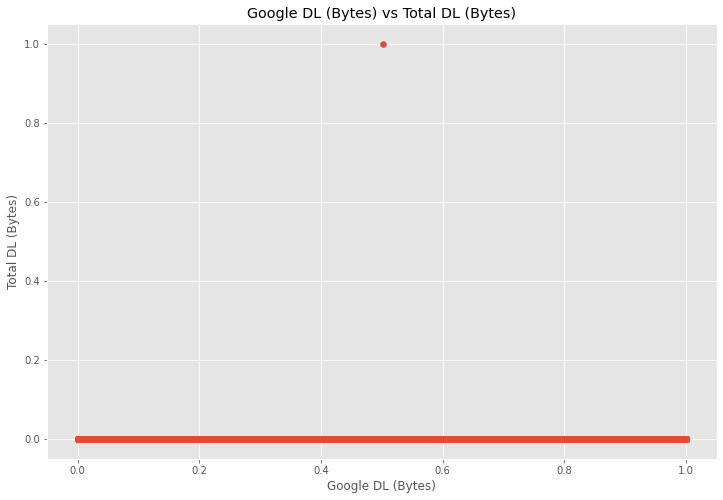

In [77]:
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=36,y=49)

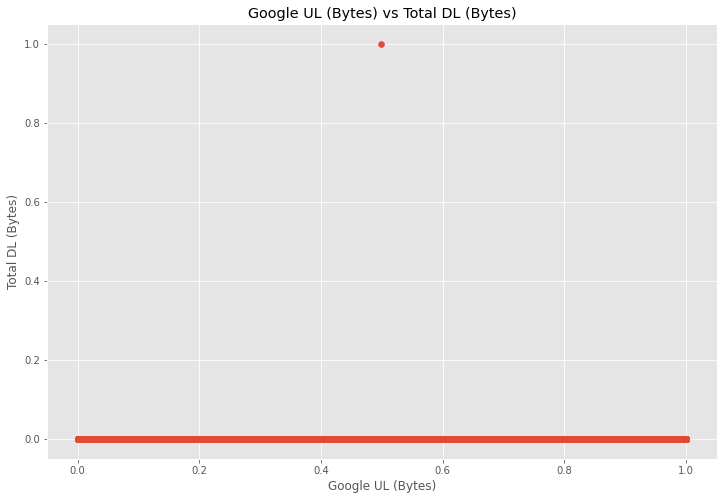

In [78]:
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=37,y=49)

In [79]:
# Correlation Analysis – compute a correlation matrix for the following variables and interpret your 
# findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data 
non_graphical_analysis(numeric_df,numerical_features,"multivariate",1,4)

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
Bearer Id,1.000000e+00,4.437695e-17,-1.531502e-18,2.320804e-14,-0.000440,-0.032220,-0.000675,0.022399,0.022431,5.848515e-14,...,-2.457872e-03,-7.009138e-04,-6.198678e-04,-3.712019e-03,4.854125e-04,-3.200768e-03,9.401555e-04,-2.232514e-03,-1.965058e-12,3.717458e-12
Start ms,4.437695e-17,1.000000e+00,1.000000e+00,1.000000e+00,0.041806,0.030519,0.041732,0.005410,0.005412,1.000000e+00,...,-1.500583e-12,-1.912409e-12,4.837108e-13,1.461500e-13,4.897382e-14,1.439816e-13,5.838543e-14,-2.309515e-13,1.000000e+00,1.000000e+00
End ms,-1.531502e-18,1.000000e+00,1.000000e+00,1.000000e+00,0.041806,0.030519,0.041732,0.005410,0.005412,1.000000e+00,...,-1.500607e-12,-1.912461e-12,4.837848e-13,1.461630e-13,4.896885e-14,1.440202e-13,5.845642e-14,-2.309628e-13,1.000000e+00,1.000000e+00
Dur. (ms),2.320804e-14,1.000000e+00,1.000000e+00,1.000000e+00,0.041806,0.030519,0.041732,0.005410,0.005412,1.000000e+00,...,-1.488637e-12,-1.905580e-12,4.780608e-13,1.290979e-13,5.115951e-14,1.497092e-13,5.717443e-14,-2.275848e-13,1.000000e+00,1.000000e+00
IMSI,-4.395742e-04,4.180587e-02,4.180587e-02,4.180587e-02,1.000000,0.730024,0.998244,0.008432,0.008731,4.180587e-02,...,3.552736e-03,-7.333612e-04,1.701018e-03,2.129500e-03,-4.239016e-04,-3.601783e-03,-2.615128e-03,4.065086e-03,4.180587e-02,4.180587e-02
MSISDN/Number,-3.221993e-02,3.051927e-02,3.051927e-02,3.051927e-02,0.730024,1.000000,0.731308,-0.002607,-0.002175,3.051927e-02,...,1.096517e-03,1.376560e-03,-1.241958e-03,2.954185e-03,9.255872e-04,-1.698653e-03,-2.272831e-03,3.991183e-03,3.051927e-02,3.051927e-02
IMEI,-6.746088e-04,4.173244e-02,4.173244e-02,4.173244e-02,0.998244,0.731308,1.000000,0.008306,0.008604,4.173244e-02,...,3.468405e-03,-6.415748e-04,1.656737e-03,1.903268e-03,-5.048970e-04,-3.506340e-03,-2.424052e-03,4.301770e-03,4.173244e-02,4.173244e-02
Avg RTT DL (ms),2.239869e-02,5.409927e-03,5.409927e-03,5.409927e-03,0.008432,-0.002607,0.008306,1.000000,0.999140,5.409927e-03,...,-1.467835e-03,1.283949e-03,-1.691073e-03,1.843591e-03,5.184558e-03,-2.761376e-04,-2.364781e-03,3.594389e-03,5.409927e-03,5.409927e-03
Avg RTT UL (ms),2.243073e-02,5.411957e-03,5.411957e-03,5.411957e-03,0.008731,-0.002175,0.008604,0.999140,1.000000,5.411957e-03,...,-1.384242e-03,1.214681e-03,-1.420897e-03,1.926927e-03,5.082968e-03,-4.687392e-04,-2.410700e-03,3.577755e-03,5.411957e-03,5.411957e-03
Avg Bearer TP DL (kbps),5.848515e-14,1.000000e+00,1.000000e+00,1.000000e+00,0.041806,0.030519,0.041732,0.005410,0.005412,1.000000e+00,...,-1.498351e-12,-1.915317e-12,4.886427e-13,1.494439e-13,4.781632e-14,1.457166e-13,6.469809e-14,-2.294802e-13,1.000000e+00,1.000000e+00


In [80]:
# pca analysis
def setup_pca(data,n):
    pca = PCA(n)
    x_ = pca.fit_transform(data)
    return x_, pca

In [84]:
def pca_analysis(df,features,no,x_,component):
    for i,key in enumerate(features):
        if i==x_:
            train = generate_transformation(numeric_pipeline,
                                         pd.DataFrame(split_data(df,key,0.3,"X_train")),
                                         "numeric","number")
            test = generate_transformation(numeric_pipeline,
                                             pd.DataFrame(split_data(df,key,0.3,"X_test")),
                                             "numeric","number")
            pca_train_results, pca_train = setup_pca(train, no)
            pca_test_results, pca_test = setup_pca(test, no)
            names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
            scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
            d = {'PCA':pca_train.components_[component], 'Variable Names':numerical_features[:x_]}
            df = pd.DataFrame({'PCA':pca_train.components_[component], 'Variable Names':numerical_features[:x_]})            
            df = df.sort_values('PCA', ascending=False)
            df2 = pd.DataFrame(df)
            df2['PCA']=df2['PCA'].apply(np.absolute)
            df2 = df2.sort_values('PCA', ascending=False)
            return df2
    return

In [82]:
pca_analysis(numeric_df,numerical_features,10,49,1)

,PCA,Variable Names
7,0.642573,Avg RTT DL (ms)
8,0.642452,Avg RTT UL (ms)
0,0.328389,Bearer Id
31,0.139193,Nb of sec with 6250B < Vol UL < 37500B
26,0.108752,Nb of sec with 125000B < Vol DL
29,0.098692,Nb of sec with 37500B < Vol UL
28,0.086268,Nb of sec with 31250B < Vol DL < 125000B
27,0.084124,Nb of sec with 1250B < Vol UL < 6250B
12,0.061395,TCP UL Retrans. Vol (Bytes)
30,0.041955,Nb of sec with 6250B < Vol DL < 31250B


In [ ]:
pca_analysis(numeric_df,numerical_features,10,49,1)

> c:\users\user\appdata\local\temp\ipykernel_10324\3212758502.py(15)pca_analysis()

ipdb> len(features)
50
ipdb> component
1
ipdb> pca_train.components_[component].shape
(49,)
ipdb> len(pca_train.components_[component])
49


In [ ]:
pca_analysis(numeric_df,numerical_features,10,47,1)

In [ ]:
pca_analysis(numeric_df,numerical_features,10,34,1)

In [ ]:
def categorize_based_on_deciles(df,features,x_):
    for i,key in enumerate(features):
        if i==x_:
            df['decile_rank'] = pd.qcut(df[key], 10,labels = False)
            return df.groupby(['decile_rank']).sum()
    return

In [ ]:
categorize_based_on_deciles(numeric_df,numerical_features,39)

In [ ]:
categorize_based_on_deciles(numeric_df,numerical_features,49)

In [ ]:
categorize_based_on_deciles(numeric_df,numerical_features,34)